In [ ]:
# coding: utf-8
# Please use Python 2.
# Check if all the required packages are installed.
# Please use Theano as backend of Keras.
# Using IPython or Jupyter Notebook to run this code is strongly recommended!
# Run line by line or block by block, and you can config some important parameters
# and output whatever you want!

In [1]:
import sys, os, collections, re, commands, csv
import nltk, codecs
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from util import *
from PairWiseRanker import *

Using Theano backend.


In [2]:
from IPython.display import clear_output

In [23]:
from copy import deepcopy

In [2]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/pkuas/chenqy/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
UNKNOWN_WORD = ':-)'

In [4]:
data_dir = 'data/'
fn = {'trn':data_dir + 'WikiQA-train.tsv', 'dev':data_dir + 'WikiQA-dev.tsv', 'test':data_dir + 'WikiQA-test.tsv'}

In [5]:
word2vec_dir = '/store1/chenqy/'
EMBEDDING_DIM = 50
word2vec_fn = word2vec_dir + 'glove.6B.%dd.txt' % EMBEDDING_DIM

In [6]:
#read_data = lambda fn : pd.read_csv(fn, sep='\t', header=0, index_col='QuestionID')
def read_data(f):
    data = pd.read_csv(f, sep='\t', header=0, quoting=csv.QUOTE_NONE)
    data['QAID'] = data['QuestionID'] + '*' + data['SentenceID']
    data.index = data['QAID']
    for col in ['Question', 'Sentence']:
        data[col] = map(lambda x : codecs.decode(x.lower(), 'UTF-8'), data[col])
    questions = dict(zip(data['QuestionID'], data['Question']))
    return data, questions

In [7]:
data, questions = {}, {}
for k in fn:
    data[k], questions[k] = read_data(fn[k])
    print k, data[k].shape, len(set(data[k]['QAID']))

test (2351, 7) 2351
dev (1130, 8) 1130
trn (20360, 8) 20360


In [8]:
data_trn, data_dev, data_test = data['trn'], data['dev'], data['test'] # for convienience

In [9]:
# distribution of number of answers each question has
for k in fn:
    if k == 'test':
        continue
    grp = data[k]['Label'].groupby(data[k]['QuestionID'])
    print k, '\n', grp.agg(lambda v : v.sum()).value_counts()

dev 
1    115
2      9
4      1
3      1
Name: Label, dtype: int64
trn 
0    1245
1     745
2     103
3      20
7       2
5       1
6       1
4       1
Name: Label, dtype: int64


In [10]:
t = set(questions['trn']), set(questions['dev']), set(questions['test'])
print len(t[0]), len(t[1]), len(t[2]), len(t[0] | t[1] | t[2]), sum([len(v) for v in t])

2118 126 243 2487 2487


In [12]:
# qtokens = {k:{qid:nltk.word_tokenize(q) for qid, q in questions[k].items() } for k in fn }

In [13]:
wnl = WordNetLemmatizer()
regex_tokenizer = RegexpTokenizer(r'\w+')
lancaster = nltk.LancasterStemmer()
def sentence2words(sent):
    res = {}
    res['tokens'] = nltk.word_tokenize(sent)
    res['words'] = regex_tokenizer.tokenize(sent)
    res['lemma'] = [wnl.lemmatize(w) for w in res['words']]
    res['stems'] = [lancaster.stem(w) for w in res['words']]
    res['words_not_stop'] = filter(lambda word : word not in stopwords.words('english'), res['words'])
    res['stems_not_stop'] = [lancaster.stem(w) for w in res['words_not_stop']]
    res['lemma_not_stop'] = [wnl.lemmatize(w) for w in res['words_not_stop']]
    return res

In [14]:
tps = ['words', 'stems', 'words_not_stop', 'stems_not_stop', 'lemma', 'lemma_not_stop']

In [15]:
sent_words = dict()

In [16]:
for k in fn:# fn:
    for qid, q in questions[k].items():
        sent_words[qid] = sentence2words(q)
    d = data[k]
    for qaid in d.index:
        sent_words[qaid] = sentence2words(d.get_value(qaid, 'Sentence'))

In [17]:
#first_word = lambda sent : sent[:sent.find(' ')]
first_token = lambda tokens : tokens[0]
second_token = lambda tokens : UNKNOWN_WORD if len(tokens) == 1 else tokens[1]
first_two_tokens = lambda tokens : ' '.join(tokens[:2])

In [18]:
for k in fn:
    for col, func in [('token1', first_token), ('token2', second_token), ('token12', first_two_tokens)]:
        qids = list(set(data[k]['QuestionID']))
        tmp = Series(map(func, map(lambda qid : sent_words[qid]['words'], qids)), index=qids)
        data[k][col] = tmp[data[k]['QuestionID']].values

In [24]:
def get_question_type(data_x):
    qtype = deepcopy(Series(data_x['token1'], index=data_x.index))
    qtype[data_x['token12'] == 'what year'] = 'time'
    qtype[data_x['token1'] == 'when'] = 'time'
    qtype[data_x['token12'] == 'how many'] = 'number'
    qtype[data_x['token1'] == 'where'] = 'place'
    qtype[data_x['token1'] == 'who'] = 'person'
    return qtype

In [25]:
len(set(data_trn.token1)), len(set(data_trn.token12)), len(set(data_trn.token2))

(5, 338, 286)

In [26]:
for k in fn:
    data[k]['qtype'] = get_question_type(data[k])

In [27]:
for k in fn:
    print k, '\n'
    for tk in ['token1', 'token12']:
        print data[k][tk].value_counts().head(10) / float(data[k].shape[0]) * 100
    print '\n'

test 

what     52.956189
how      16.205870
who      11.569545
where    10.421097
when      8.847299
Name: token1, dtype: float64
what is      22.288388
what are      5.827308
when did      5.784772
how many      5.019141
what year     3.487877
where was     2.934921
where is      2.892386
what does     2.722246
how did       2.254360
who is        2.254360
Name: token12, dtype: float64


dev 

what        56.194690
how         12.035398
when        11.946903
where       10.000000
who          9.646018
whatever     0.176991
Name: token1, dtype: float64
what is      14.424779
what are     10.265487
when did      9.203540
how many      6.725664
where is      5.132743
what does     4.070796
what was      3.982301
what year     3.539823
who is        2.743363
when was      2.743363
Name: token12, dtype: float64


trn 

what     49.695481
how      20.859528
who      12.568762
when      9.228880
where     7.647348
Name: token1, dtype: float64
what is      19.965619
how many      7.509823
wh

In [28]:
import math

words_idf = dict()
for tp in tps:
    words_idf[tp] = dict()

for tp in tps:
    for qaid in sent_words:
        for word in set(sent_words[qaid][tp]):
            if (word in words_idf[tp]) == True:
                words_idf[tp][word] = words_idf[tp][word] + 1
            else:
                words_idf[tp][word] = 1

DocNum = len(sent_words)
for tp in tps:
    for w in words_idf[tp]:
        words_idf[tp][w] = math.log(DocNum / words_idf[tp][w], 2)


In [29]:
def count_num_cooccur_weight(x, y, tp):
    z = set(x) & set(y)
    s = 0
    for w in z:
        s = s + words_idf[tp][w]
    return s

In [30]:
#word embedding:
# readEmbedFile
from word2vec_util import * 
wordvecs = readEmbedFile(word2vec_fn)
dim = EMBEDDING_DIM

wordset2 = set()
for tp in tps:
    for w in words_idf[tp]:
        wordset2.add(w)

new_wv=dict()
for w in wordvecs:
    if (w in wordset2) == True:
        new_wv[w] = wordvecs[w]
wordvecs = new_wv
new_wv = dict()

In [31]:
#using this!!!
def count_wv_dis(x, y):
    vx = [0 for c in range(dim)]
    wn = 0
    for w in x:
        if w in wordvecs:
            wn = wn + 1
            for d in range(dim):
                vx[d] += wordvecs[w][d]
    if wn > 0:
        for d in range(dim):
            vx[d] /= wn
    vy = [0 for c in range(dim)]
    wn = 0
    for w in y:
        if w in wordvecs:
            wn = wn + 1
            for d in range(dim):
                vy[d] += wordvecs[w][d]
    if wn > 0:
        for d in range(dim):
            vy[d] /= wn
    dis = 0;
    for d in range(dim):
        dis += (vx[d] - vy[d])*(vx[d] - vy[d])
    return 0 - dis # larger, better

def count_wv_dis_weight(x, y, tp):
    vx = [0 for c in range(dim)]
    wn = 0
    for w in x:
        if w in wordvecs:
            wn = wn + words_idf[tp][w]
            for d in range(dim):
                vx[d] += wordvecs[w][d]*words_idf[tp][w]
    if wn > 0:
        for d in range(dim):
            vx[d] /= wn
    vy = [0 for c in range(dim)]
    wn = 0
    for w in y:
        if w in wordvecs:
            wn = wn + words_idf[tp][w]
            for d in range(dim):
                vy[d] += wordvecs[w][d]*words_idf[tp][w]
    if wn > 0:
        for d in range(dim):
            vy[d] /= wn
    dis = 0;
    for d in range(dim):
        dis += (vx[d] - vy[d])*(vx[d] - vy[d])
    return 0 - dis # larger, better

# for k in fn:
#     d = data[k]
#     for tp in tps:
#         func = lambda qaid : count_wv_dis_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
#         features[k][tp] = d['QAID'].apply(func)

In [33]:
encode = lambda s : codecs.encode(s, 'UTF-8')
ques_utf8 = {}
sent_utf8 = {}
for k in fn:
    for qid, q in questions[k].items():
        ques_utf8[qid] = encode(q)
    d = data[k]
    for qaid in d.index:
        sent_utf8[qaid] = encode(d.get_value(qaid, 'Sentence'))

texts = []
texts.extend(ques_utf8.values())
texts.extend(sent_utf8.values())
tokenizer = Tokenizer(nb_words=None)
tokenizer.fit_on_texts(texts)
ques_seq = {qid:tokenizer.texts_to_sequences([tx])[0] for qid, tx in ques_utf8.items()}
sent_seq = {qaid:tokenizer.texts_to_sequences([tx])[0] for qaid, tx in sent_utf8.items()}
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print max([len(seq) for seq in ques_seq.values()]), max([len(seq) for seq in sent_seq.values()])
# MAX_SENT_SEQUENCE_LENGTH = max([max([len(seq) for seq in sents_seq[k]]) for k in fn])
ques_len = Series([len(q) for q in ques_seq.values()])
sent_len = Series([len(s) for s in sent_seq.values()])
MAX_QUES_SEQUENCE_LENGTH, MAX_SENT_SEQUENCE_LENGTH = 20, 60

 Found 35188 unique tokens.
23 165


In [34]:
word2vec = pd.read_csv(word2vec_fn, sep=' ', header=None, index_col=0, nrows=None, quoting=csv.QUOTE_NONE)
embedding_index = {}
for i, w in enumerate(word2vec.index):
    embedding_index[w] = word2vec.values[i]

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

words_bag = set(word2vec.index)

In [35]:
words_idf_series = {tp:Series(words_idf[tp].values(), index=words_idf[tp].keys()) for tp in words_idf}

In [36]:
def words_of_sentence_to_vector(words, tp, use_weight=True):
    shp = (len(words), EMBEDDING_DIM)
    try:
        if use_weight:
            weight = np.repeat(words_idf_series[tp].loc[words], EMBEDDING_DIM).values.reshape(shp)
            return (word2vec.loc[words] * weight).mean().values    
        else:
            return (word2vec.loc[words]).mean().values
    except: # none of words are in word2vec
        return np.zeros(shp)
def get_sent_vetor_df(q_words):
    q_vecs = dict(zip(q_words.keys(), map(lambda words : words_of_sentence_to_vector(words, 'words', use_weight=False), q_words.values())))
    q_vecs = DataFrame(q_vecs).T
    q_vecs_wgt = dict(zip(q_words.keys(), map(lambda words : words_of_sentence_to_vector(words, 'words', use_weight=True), q_words.values())))
    q_vecs_wgt = DataFrame(q_vecs_wgt).T
    #q_vecs_wgt.columns = map(lambda col : col)
    q_vecs_merged = pd.concat([q_vecs, q_vecs_wgt], axis=1)
    return q_vecs_merged

## calculate features

In [37]:
features = {key:DataFrame({}, index=data[key].index) for key in fn}
features_trn = features['trn']
features_dev = features['dev']
features_test = features['test']
tps_wgt = map(lambda v : v + '_wgt', tps)
tps_wv = map(lambda v : v + '_wv', tps)
tps_wv_wgt = map(lambda v : v + '_wgt', tps_wv)

In [38]:
# words, stems
for k in fn:
    d = data[k]
    for tp in tps:
        func = lambda qaid : count_num_cooccur(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp])
        features[k][tp] = d['QAID'].apply(func)
        func = lambda qaid : count_num_cooccur_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
        features[k][tp + '_wgt'] = d['QAID'].apply(func)
        func = lambda qaid : count_wv_dis(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp])
        features[k][tp + '_wv'] = d['QAID'].apply(func)
        func = lambda qaid : count_wv_dis_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
        features[k][tp + '_wv_wgt'] = d['QAID'].apply(func)

In [39]:
# question type
for k in fn:
    f, d = features[k], data[k]
    for col in ['token1', 'qtype']:
        f[col] = data[k][col]
    f['qtype_time'] = (d['qtype'] == 'time') + 0
    f['qtype_number'] = (d['qtype'] == 'number') + 0
    f['year'] = map(lambda sent : int(re.search('[0-9]{4}', sent) != None), d.Sentence)
    f['number'] = map(lambda sent : int(re.search('[0-9]+', sent) != None), d.Sentence)
    f['number'] = f['number'] - f['year']
    f['num_unknown'] = map(lambda words : len(set(words) - words_bag), #np.sum(np.logical_not(np.in1d(words, word2vec.index)))
                           map(lambda qaid : sent_words[qaid]['words'], d.index))

In [40]:
# qa_vectors = {}
# for k in fn:
#     q_words = {qid:sent_words[qid]['words'] for qid in set(data[k]['QuestionID'])}
#     q_vec_df = get_sent_vetor_df(q_words)
#     q_vec_df = q_vec_df.loc[data[k]['QuestionID']]
#     q_vec_df.index = data[k].index
#     a_words = {qaid:sent_words[qaid]['words'] for qaid in data[k].index}
#     a_vec_df = get_sent_vetor_df(a_words)
#     qa_vectors[k] = pd.concat([q_vec_df, a_vec_df], axis=1)

In [41]:
dummies = {}
features_all = pd.concat(features.values(), axis=0)
dummies_all = pd.get_dummies(features_all)

In [42]:
features_all.shape, dummies_all.shape

((23841, 31), (23841, 42))

In [43]:
idx = 0
k_all = fn.keys()
for i in range(len(k_all)):
    k = k_all[i]
    new_idx = idx + data[k].shape[0]
    dummies[k] = dummies_all.iloc[idx:new_idx]
    print k, idx, new_idx, dummies[k].shape, data[k].shape
    idx = new_idx

test 0 2351 (2351, 42) (2351, 11)
dev 2351 3481 (1130, 42) (1130, 12)
trn 3481 23841 (20360, 42) (20360, 12)


In [44]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [45]:
from learning2rank.rank import RankNet, ListNet
# reload(RankNet)
# reload(ListNet)

In [46]:
models = {}

In [47]:
indiv = [1560, 'entropy', 3, 5, 5] # (0.68945635493254542,) # 0.68482672530291577,) [48, 'gini', 3, 2, 4] #(0.68573375478137377,) [1734, 'entropy', 5, 3, 4] # (0.68961935330982949,)  # 49, 'entropy', 13, 3, 5]
models['rf'] = model_rf = RandomForestClassifier(n_estimators=indiv[0], criterion=indiv[1], 
                                                 max_depth=indiv[2], min_samples_split=indiv[3], 
                                                 min_samples_leaf=indiv[4], n_jobs=-1) # 

In [48]:
#models['ada'] = model_ada = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=.5, algorithm='SAMME.R', random_state=None)

In [49]:
models['lr_l1'] = model_lr_l1 = LogisticRegression(penalty='l1', n_jobs=-1)
models['lr_l2'] = model_lr_l2 = LogisticRegression(penalty='l2', n_jobs=-1)

In [50]:
#models['svm'] = model_svm = SVC(probability=True)

In [51]:
rk_models = {}

In [52]:
rk_models['ranknet'] = rk_model_ranknet = RankNet.RankNet(silent=True)

In [53]:
#rk_models['listnet'] = rk_model_listnet = ListNet.ListNet(silent=True)

In [54]:
my_models = {}
pair_ranker = PairWiseRanker(data_trn.QuestionID, dummies['trn'], data_trn.Label)

In [55]:
# from ParamGA import * 
# g = RFGA(data_trn.QuestionID, dummies['trn'], data_trn.Label, data_dev.QuestionID, dummies['dev'], data_dev.Label, pair_wise=False)
# g.run(NPOP=30, NGEN=20, CXPB=0.5, MUTPB=0.5)

In [56]:
indiv =[327, 'gini', 5, 5, 1] #  (0.69239713108760736,)  # [746, 'gini', 7, 6, 4] #[746, 'gini', 7, 6, 4] # 0.679 
# (0.69028072897120518,) [352, 'entropy', 5, 4, 5] # (0.69001617870665499,) [1977, 'gini', 6, 4, 5]
my_models['my_rf'] = my_models_rf = RandomForestClassifier(n_estimators=indiv[0], criterion=indiv[1], 
                                                 max_depth=indiv[2], min_samples_split=indiv[3], 
                                                 min_samples_leaf=indiv[4], n_jobs=-1)

In [57]:
for mn, md in models.items():
    md.fit(dummies['trn'].values, data_trn.Label)

/home/pkuas/chenqy/anaconda2/lib/python2.7/site-packages/numpy/lib/shape_base.py:422: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))
  0%|          | 5/5000 [00:00<01:40, 49.73it/s]

load dataset
('The number of data, train:', 19342, 'validate:', 1018)
prepare initialized model!


100%|██████████| 5000/5000 [00:46<00:00, 106.58it/s]


save the model
save the optimizer


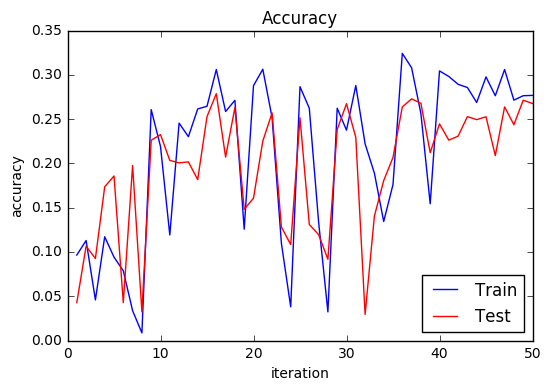

In [58]:
# %%capture
for mn in rk_models: # ['listnet']: # 
    args = {}
    if mn == 'ranknet':
        args = {} # {'batchsize':100, 'n_iter':5000, 'n_units1':512, 'n_units2':128, 'tv_ratio':0.95}
    elif mn == 'listnet':
        args = {'batchsize':100, 'n_epoch':1, 'n_units1':32, 'n_units2':16, 'tv_ratio':0.9}
    rk_models[mn].fit(dummies['trn'].values, data_trn.Label, **args)

# clear_output()

In [59]:
for mn in my_models:
    pair_ranker.fit(my_models[mn], mn)

In [60]:
#Series(model_rf.feature_importances_, index=features_trn.columns).sort_values(ascending=False)

In [61]:
sfn = fn.keys() # specify a subset of fn

In [62]:
preds = {k:{mn:md.predict_proba(dummies[k]) for mn, md in models.items()} for k in sfn}

In [63]:
rk_preds = {k:{mn:md.predict(dummies[k].values) for mn, md in rk_models.items()} for k in sfn}

In [64]:
my_preds = {k:{mn:pair_ranker.predict(data[k]['QuestionID'], dummies[k], mn) for mn in my_models} for k in sfn}

In [65]:
ranks = {k:deepcopy(dummies[k]) for k in fn}
dummy_rank_features = {k:deepcopy(dummies[k]) for k in fn}
rank_trn, rank_dev, rank_test = ranks['trn'], ranks['dev'], ranks['test']
all_tps = tps + tps_wgt + tps_wv + tps_wv_wgt + models.keys() + rk_models.keys() + my_models.keys()
for k in sfn:
    rk = ranks[k]
    for col in ['QuestionID', 'SentenceID']:
        rk[col] = data[k][col]
    if k != 'test':
        rk['Label'] = data[k]['Label']
    for mn in models:
        rk[mn] = preds[k][mn][:, 1] # larger is better
    for mn in rk_models:
        rk[mn] = rk_preds[k][mn][:, 0]
    for mn in my_models:
        rk[mn] = my_preds[k][mn]
    grp = rk.groupby('QuestionID')
    for tp in all_tps:
        col = 'rank_' + tp
        rk[col] = grp[tp].rank(method='min', ascending=False).astype(int)  
        rk.sort_values(['QuestionID', col], inplace=True)
        # add one Strictly Increasing Monotonically vector to avoid same ranks
        b = np.ones(rk.shape[0]).cumsum()
        rk[col] += b
        grp = rk.groupby('QuestionID')
        rk[col] = grp[col].rank(method='min', ascending=True).astype(int)  
        dummy_rank_features[k][col] = rk[col]

In [66]:
for k in sfn:
    if k in ['test', 'trn']:
        continue
    print k
    rk = ranks[k]
    for tp in all_tps:
        col = 'rank_' + tp
        rk.sort_values(['QuestionID', col], inplace=True)
        grp = rk.Label.groupby(rk.QuestionID)
        print '\t', '{: <20}'.format(tp), np.round([MAP(grp), MRR(grp), MAP(grp, keep_no_ans=False), MRR(grp, keep_no_ans=False)], 5)

dev
	words                [ 0.66772  0.67436  0.66772  0.67436]
	stems                [ 0.66973  0.67913  0.66973  0.67913]
	words_not_stop       [ 0.65747  0.66276  0.65747  0.66276]
	stems_not_stop       [ 0.67028  0.67904  0.67028  0.67904]
	lemma                [ 0.67349  0.68225  0.67349  0.68225]
	lemma_not_stop       [ 0.68214  0.6909   0.68214  0.6909 ]
	words_wgt            [ 0.65222  0.65798  0.65222  0.65798]
	stems_wgt            [ 0.6847   0.69353  0.6847   0.69353]
	words_not_stop_wgt   [ 0.66889  0.67507  0.66889  0.67507]
	stems_not_stop_wgt   [ 0.66975  0.67792  0.66975  0.67792]
	lemma_wgt            [ 0.68184  0.69041  0.68184  0.69041]
	lemma_not_stop_wgt   [ 0.68163  0.6902   0.68163  0.6902 ]
	words_wv             [ 0.59265  0.59182  0.59265  0.59182]
	stems_wv             [ 0.58874  0.5895   0.58874  0.5895 ]
	words_not_stop_wv    [ 0.62636  0.631    0.62636  0.631  ]
	stems_not_stop_wv    [ 0.54792  0.55225  0.54792  0.55225]
	lemma_wv             [ 0.58557  0.5

In [67]:
# #res = collections.defaultdict(dict)
# print sfn, '\n'
# print ' ' * 15, '{: >15}\t{: >15}'.format('MAP', 'MRR') 
# for tp in tps + tps_wgt + models.keys() + rk_models.keys() + my_models.keys(): # ['rf']: #
#     print '{: >20}'.format(tp), 
#     for k in sfn:
#         if k in ['test', 'trn']:
#             continue
#         col = 'rank_' + tp
#         ranks[k][['QuestionID', 'SentenceID', col]].sort_values(['QuestionID', col]).to_csv('rank.txt', sep='\t', header=False, index=False)
#         out = commands.getoutput('python eval.py rank.txt %s' % fn[k])
#         m = re.search('MAP: ([.0-9]+)\nMRR ([.0-9]+)', out)
#         print '\t%f\t%f' % (float(m.group(1)), float(m.group(2))),' ',
#     print ''

In [68]:
def rank_and_evaluate(y, k):
    '''
    if k is 'test', then this func will only rank, not evaluate 
    '''
    d = DataFrame({}, data[k].index)
    d['y'] = y
    cols = ['QuestionID', 'SentenceID']
    if k != 'test':
        cols.append('Label')
    for col in cols:
        d[col] = data[k][col]
    
    
    grp = d.groupby('QuestionID')
    d['rank'] = grp['y'].rank(method='min', ascending=False).astype(int)    
    
    d.sort_values(['QuestionID', 'rank'], inplace=True)
    res = dict()
    res['rank_df'] = d
    if k == 'test':
        return res
    grp = d.Label.groupby(d.QuestionID)
    res['my_MAP'] = MAP(grp, keep_no_ans=False)
    res['my_MRR'] = MRR(grp, keep_no_ans=False)
    d[['QuestionID', 'SentenceID', 'rank']].sort_values(['QuestionID', 'rank']).to_csv('rank.txt', sep='\t', header=False, index=False)
    out = commands.getoutput('python eval.py rank.txt %s' % fn[k])
    m = re.search('MAP: ([.0-9]+)\nMRR ([.0-9]+)', out)
    res['MAP'] = float(m.group(1))
    res['MRR'] = float(m.group(2))
    return res    

def save_final_rank(df, dst_fn='final_rank.txt', rank_col='rank', 
                    save_cols=['QuestionID', 'SentenceID', 'rank'], sort_by_cols=['QuestionID', 'rank'], re_rank=False):
    if re_rank:
        col = rank_col
        df.sort_values(['QuestionID', col], inplace=True)
        # add one Strictly Increasing Monotonically vector to avoid same ranks
        b = np.ones(df.shape[0]).cumsum()
        df[col] += b
        grp = df.groupby('QuestionID')
        df[col] = grp[col].rank(method='min', ascending=True).astype(int)  
    df[save_cols].sort_values(sort_by_cols).to_csv(dst_fn, sep='\t', header=False, index=False)    

def resample(rt, Xs, Y):
    if rt == None or rt == 0:
        return Xs, Y
    n = Y.shape[0]
    n1 = Y.sum()
    n0 = n - n1
    cls_idx = np.arange(n)
    pos_cls_idx = cls_idx[Y==1]
    neg_cls_idx = cls_idx[Y==0]
    pos_sample = np.random.choice(pos_cls_idx, size=int(n0 / float(rt)) - n1, )
    new_cls_idx = np.concatenate([neg_cls_idx, pos_cls_idx, pos_sample])
    np.random.shuffle(new_cls_idx)
    print n0, n1, n, int(n0 / float(rt)) - n1, new_cls_idx.shape
    new_Y = Y[new_cls_idx]
    new_Xs = [X[new_cls_idx] for X in Xs]
    return new_Xs, new_Y


In [69]:
#ques_len.hist()

In [70]:
#sent_len.hist()
#sent_len[sent_len<200].hist()

In [72]:
from keras.preprocessing.sequence import pad_sequences
sent_pad = dict(zip(sent_seq.keys(), pad_sequences(sent_seq.values(), maxlen=MAX_SENT_SEQUENCE_LENGTH, padding='post', truncating='post')))
ques_pad = dict(zip(ques_seq.keys(), pad_sequences(ques_seq.values(), maxlen=MAX_QUES_SEQUENCE_LENGTH, padding='post', truncating='post')))
ques_as_sent_pad = dict(zip(ques_seq.keys(), pad_sequences(ques_seq.values(), maxlen=MAX_SENT_SEQUENCE_LENGTH, padding='post', truncating='post')))

In [73]:
sent_pad_df = DataFrame(sent_pad.values(), index=sent_pad.keys())

In [74]:
ques_pad_df = DataFrame(ques_pad.values(), index=ques_pad.keys())

In [75]:
ques_as_sent_pad_df = DataFrame(ques_as_sent_pad.values(), index=ques_as_sent_pad.keys())

In [76]:
paddata = collections.defaultdict(dict)
for k in fn:
    paddata[k] = {'ques':ques_pad_df.loc[data[k]['QuestionID']], 
                  'ques_as_sent':ques_as_sent_pad_df.loc[data[k]['QuestionID']],
                  'sent':sent_pad_df.loc[data[k]['QAID']]}

In [77]:
num_output_class = 1

In [79]:
label = {}
for k in sfn:
    if k == 'test':
        continue
    tmp = data[k]['Label'].values
    if num_output_class == 1:
        label[k] = tmp
    elif num_output_class == 2:
        label[k] = np.array([1 - tmp, tmp]).T

## adapted CNN

In [80]:
use_add_features = True
num_output_class = 1
features_used = dummy_rank_features
add_features_dim = features_used['trn'].shape[1] if use_add_features else None
X, Y = {}, {}
for k in sfn:
    X[k] = [paddata[k]['ques'].values, paddata[k]['sent'].values]
    if k != 'test':
        Y[k] = label[k]
    if use_add_features:
        X[k].append(features_used[k].values)

In [82]:
from MyCNN import *
cnn = MyCNN(embedding_matrix, word_index, MAX_QUES_SEQUENCE_LENGTH, MAX_SENT_SEQUENCE_LENGTH, add_features_dim)

In [83]:
cnn.init_model(num_filters=100, filter_size=5, pool_length=2, 
               denses=[100], dropouts=[0], activations=['relu'],
               num_output_class=num_output_class)

In [84]:
#new_Xs, new_Y = resample(0, X['trn'], Y['trn'])
cnn.fit(X['trn'], Y['trn'], validation_data=(X['dev'], Y['dev']), nb_epoch=2, batch_size=50) # data['trn'].shape[0]) # 

Train on 20360 samples, validate on 1130 samples
Epoch 1/2
20360/20360 [==============================] - 13s - loss: 0.1842 - acc: 0.9474 - val_loss: 0.4068 - val_acc: 0.8761
Epoch 2/2
20360/20360 [==============================] - 13s - loss: 0.1741 - acc: 0.9483 - val_loss: 0.3135 - val_acc: 0.8770


In [86]:
res = {}
for k in sfn:
    if k in ['trn', 'test']:
        continue
    y = cnn.predict(X[k])
    res[k] = rank_and_evaluate(y[:, 0], k)
    print k
    for m in ['my_MAP', 'my_MRR', 'MAP', 'MRR']:
        print m, '\t', res[k][m]

dev
my_MAP 	0.681653212308
my_MRR 	0.685950293093
MAP 	0.681653212308
MRR 	0.685950293093


In [ ]:
# model.save('model/cnn_2d_%d_%f_%f.h5' % (add_features_dim, res['dev']['MRR'], res['testx']['MRR']))

## adapted LSTM

In [89]:
from MyLSTM import *

In [90]:
# prepare X and Y
use_add_features = True
features_used = dummy_rank_features # dummies 
add_features_dim = features_used['trn'].shape[1] if use_add_features else None
X, Y = {}, {}
for k in sfn:
    X[k] = [paddata[k]['ques_as_sent'].values, paddata[k]['sent'].values]
    if k != 'test':
        Y[k] = label[k]
    if use_add_features:
        X[k].append(features_used[k].values)

In [91]:
model = MyLSTM(embedding_matrix, word_index, MAX_SENT_SEQUENCE_LENGTH, add_features_dim)

In [95]:
model.init_model(lstm_output_dim=64, denses=[64], dropouts=[0])

In [98]:
#np.random.seed(1337)
model.fit(X['trn'], Y['trn'], validation_data=(X['dev'], Y['dev']), nb_epoch=2, batch_size=64)

Train on 20360 samples, validate on 1130 samples
Epoch 1/2
20360/20360 [==============================] - 57s - loss: 0.1669 - acc: 0.9485 - val_loss: 0.3003 - val_acc: 0.8850
Epoch 2/2
20360/20360 [==============================] - 56s - loss: 0.1646 - acc: 0.9485 - val_loss: 0.3484 - val_acc: 0.8770


In [99]:
res = {}
for k in sfn:
    if k in ['trn', 'test']:
        continue
    y = model.predict(X[k])
    res['y'] = y
    res[k] = rank_and_evaluate(y, k)
    print k
    for m in ['my_MAP', 'my_MRR', 'MAP', 'MRR']:
        print m, '\t', res[k][m]

dev
my_MAP 	0.685823839594
my_MRR 	0.691201126915
MAP 	0.685823839594
MRR 	0.691201126915


In [103]:
# model.save('model/lstm_2d_%d_%f_%f.h5' % (add_features_dim, res['dev']['MRR'], res['testx']['MRR']))

In [106]:
# from keras.models import load_model
# model = load_model('model/lstm.1337.709692.663293.h5')

## predict and save

In [108]:
# predict on test dataset
k = 'test'
y = model.predict(X[k])
tres = rank_and_evaluate(y, k)
save_final_rank(tres['rank_df'], dst_fn='final_rank.txt', rank_col='rank', 
                    save_cols=['QuestionID', 'SentenceID', 'rank'], sort_by_cols=['QuestionID', 'rank'], re_rank=False)

print 'Done'

Done
